# Law, Order, and Algorithms
## Included-variable bias

In this lab, we will investigate how to use a regression model to measure disparities across different groups, and discuss some of the problems that might arise in doing so. We will use the NYC stop and frisk data we have been using in previous labs.

In [1]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Read the data. For computational reasons, we'll work with a sample of the data.
# We also exclude rare suspected crime categories, and relevel 
# the race variable so that "white" is the base category
set.seed(1)
stop_df <- read_rds("../data/sqf_sample.rds") %>%
  sample_n(1e4)%>%
  group_by(suspected_crime) %>%
  filter(n() >= 10) %>%
  ungroup() %>%
  mutate(suspect_race = relevel(suspect_race, "white"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


The loaded data frame is a sample of stops in NYC, recorded on a 
[UF-250 form][uf250_link]

Below is a list of columns in the data, roughly corresponding to the [UF-250 form][uf250_link]:

* Base information regarding stop:
    * `id`, `year`, `date`, `time`, `precinct`, `location_housing`, 
      `suspected_crime`

* Circumstances which led to stop:
    * `stopped_bc_object`, `stopped_bc_desc`, `stopped_bc_casing`,
      `stopped_bc_lookout`, `stopped_bc_clothing`, `stopped_bc_drugs`,
      `stopped_bc_furtive`, `stopped_bc_violent`, `stopped_bc_bulge`,
      `stopped_bc_other` 
    
* Suspect demographics:
    * `suspect_dob`, `suspect_id_type`, `suspect_sex`, `suspect_race`,
      `suspect_hispanic`, `suspect_age`, `suspect_height`, `suspect_weight`,
      `suspect_hair`, `suspect_eye`, `suspect_build`, `reason_explained`,
      `others_stopped`

* Whether physical force was used:
    * `force_hands`, `force_wall`, `force_ground`, `force_drawn`,
      `force_pointed`, `force_baton`, `force_handcuffs`,
      `force_pepper`, `force_other`

* Was suspect arrested?: `arrested`

* Was summons issued?: `summons_issued`

* Officer in uniform?: `officer_uniform`, `officer_verbal`, `officer_shield`

* Was person frisked?: `frisked`
    * if yes: `frisk_reason_suspected_crime`, `frisk_reason_weapons`, 
      `frisk_reason_attire`, `frisk_reason_actual_crime`, 
      `frisk_reason_noncompliance`, `frisk_reason_threats`,
      `frisk_reason_prior`, `frisk_reason_furtive`, `frisk_reason_bulge`

* Was person searched?: `searched`,
    * if yes: `searched_hardobject`, `searched_outline`,
      `searched_admission`, `searched_other`

* Was weapon found?: `found_weapon`
    * if yes: `found_gun`, `found_pistol`, `found_rifle`, `found_assault`,
      `found_knife`, `found_machinegun`, `found_other`
      
* Was other contraband found?: `found_contraband`

* Additional circumstances/factors
    * `additional_report`, `additional_investigation`, `additional_proximity`, 
      `additional_evasive`, `additional_associating`, `additional_direction`, 
      `additional_highcrime`, `additional_time`, `additional_sights`, 
      `additional_other`

* Additional reports prepared: `extra_reports`

[uf250_link]: https://www.prisonlegalnews.org/media/publications/Blank%20UF-250%20Form%20-%20Stop%2C%20Question%20and%20Frisk%20Report%20Worksheet%2C%20NYPD%2C%202016.pdf

## Base rate disparities in the decision to frisk

First, let's measure the disparities in police decisions to frisk individuals of different race groups.

### Exercise 1: manual computation of odds and odds ratios

* **Step 1**: For each race group, compute the proportion that were frisked

In [2]:
# With the stop_df data, group by suspect_race and compute the proportion (mean) of frisked == 1
# WRITE CODE HERE
# START solution
p_frisked_df <- stop_df %>%
    group_by(suspect_race) %>%
    summarize(p_frisked = mean(frisked))
# END solution

`summarise()` ungrouping output (override with `.groups` argument)


* **Step 2**: Given probability $p$ of being frisked, the *odds* of being frisked is computed as $p / (1-p)$. 

For example, if $p = \frac{1}{2}$, you're equally likely to be frisked or not (i.e., odds = 1); if $p = \frac{2}{3}$, you're twice as likely to be frisked than not (odds = 2).

Using the proportion frisked from Step 1 as an estimate of the probability of being frisked, compute the *odds* of being frisked for each race group.

In [3]:
# Compute the odds, p / (1-p), where p is the proportion from step 1
# WRITE CODE HERE
# START solution
odds_df <- p_frisked_df %>%
    mutate(odds = p_frisked / (1 - p_frisked))
# END solution

* **Step 3**: A common method of comparing odds between two groups is to compute the *odds ratio*. 
This is simply the ratio between two odds.

For example, if the odds of being frisked is 0.8 for white pedestrians and 1.6 for Black pedestrians, the odds ratio of being frisked for Black vs. white pedestrians would be $1.6 / 0.8 = 2$. In other words, we would say stopped Black pedestrians have twice the odds of being frisked, compared to stopped white pedestrians.

Using the odds computed in Step 2, compute the odds ratio for minority groups (Black / Hispanic) versus white individuals.

In [4]:
# Compute odds of frisk for minority race group / odds of frisk for whites
# WRITE CODE HERE
# START solution

odds_black <- filter(odds_df, suspect_race == "black") %>% pull('odds')
odds_hispanic <- filter(odds_df, suspect_race == "hispanic") %>% pull('odds')
odds_white <- filter(odds_df, suspect_race == "white") %>% pull('odds')

cat("Black-white odds ratio:", odds_black / odds_white, "\n")
cat("Hispanic-white odds ratio:", odds_hispanic / odds_white)
# END solution

Black-white odds ratio: 1.76 
Hispanic-white odds ratio: 1.92

### Base rate disparities with (logistic) regression

Another method for comparing differences in frisk rates is to use regression. 
Specifically, logistic regression is commonly used for binary decisions (e.g., where the decision is either "frisk" or "don't frisk").

In `R` we use the `glm` function to fit *generalized* linear models (e.g., logistic regression, poisson regression). 
In its simplest form, the `glm` function is specified with a `formula`, the `data`, and a `family` which indicates what type of regression is used.
A `formula` in `R` is specified in the form: `Left-hand-side variable ~ Right-hand-side specifications`.
For example, to fit a logistic regression (which is of the `"binomial"` family) of `frisked` to the `suspect_race` variable, using the `stop_df` data, we can write:

In [5]:
base_model <- glm(frisked ~ suspect_race, data = stop_df, family = binomial)

where the first argument to `glm` is assumed to be the `formula`. 

Using mathematical notation, this corresponds to the model:
$$
\Pr(\text{frisked}) = \operatorname{logit}^{-1}(
    \beta_0 + \beta_{\text{black}}\mathbb{1}_{\text{black}} + 
    \beta_{\text{Hispanic}}\mathbb{1}_{\text{Hispanic}}
),
$$
where
$$
\operatorname{logit}^{-1}(x) = 
\frac{e^{x}}{1 + e^{x}}
$$
and
$$
\operatorname{logit}(p) = \log\left(\frac{p}{1-p}\right).
$$

As a result
$$
\log\left(\frac{\Pr(\text{frisked})}
{1 - \Pr(\text{frisked})}\right) = 
\beta_0 + \beta_{\text{black}}\mathbb{1}_{\text{black}} + 
    \beta_{\text{Hispanic}}\mathbb{1}_{\text{Hispanic}},
$$
and so
$$
\frac{\Pr(\text{frisked})}{1 - \Pr(\text{frisked})}  = 
\exp\left(\beta_0 + \beta_{\text{black}}\mathbb{1}_{\text{black}} + 
    \beta_{\text{Hispanic}}\mathbb{1}_{\text{Hispanic}}\right).
$$

From the above model, $\exp(\beta_0)$ is the odds of being frisked for white individuals and $\exp(\beta_0+\beta_{\text{black}}) = \exp(\beta_0)\exp(\beta_{\text{black}})$ is the odds of being frisked for black individuals.
Consequently, the odds _ratio_ of being frisked for black vs. white pedestrians is $\exp(\beta_{\text{black}})$: the exponentiated coefficient of
the variable indicating whether a pedestrian's race group is black or not.

We can inspect the coefficients of the fitted model using the `coef()` function.

In [6]:
print(coef(base_model))

                (Intercept)           suspect_raceasian 
                     -0.309                       0.342 
          suspect_raceblack suspect_racenative american 
                      0.568                       0.437 
       suspect_racehispanic           suspect_raceother 
                      0.651                       0.444 


As we've seen above, the `(Intercept)` ($\beta_0$) term corresponds to the _log_-odds of being frisked for stopped white individuals, while the `suspect_raceblack` coefficient represents the change in *log*-odds (log of odds ratio) of being frisked for black individuals compared to white individuals. By exponentiating the coefficients, we can recover the odds of being frisked for whites and odds-ratio of being frisked for each minority race group with respect to whites.

In [7]:
# Exponentiating the coefficients recover odds ratio of treatment for each variable; 
# identical to what we find in Exercise 1, 
# while the exponentiated intercept represents the odds of treatment for the base case (whites) 
print(exp(coef(base_model)))

                (Intercept)           suspect_raceasian 
                      0.734                       1.408 
          suspect_raceblack suspect_racenative american 
                      1.765                       1.548 
       suspect_racehispanic           suspect_raceother 
                      1.917                       1.560 


## Adjusting for other variables

One concern is that officers might have a legitimate reason to frisk certain individuals more often; it might just be that the "legitimate reason" is also highly correlated with race.

For example, as we discussed in earlier, one of the reasons for stopping an individual is if the officer suspects criminal posession of a weapon (encoded in the `suspected_crime` column as `cpw`).
Given that the primary justification of a frisk is concern for officer safety, one could argue that it is reasonable for an officer to 
frisk individuals whom they have stopped under suspicion of criminal posession of weapons.

(Although, whether an officer's _suspicion_ itself is justified is a different question, which we will address later)

### Adjusting for `suspected_crime == "cpw"` 

Given a regression model, we can "adjust for" additional variables in our data by including them in the right-hand side of our formula.

### Exercise 2: 

With `stop_df`, first create a new binary column named `is_cpw` that is `TRUE` if `suspected_crime` is `cpw`. Then fit a model that adjusts for this new covariate, and discuss the results.

In [8]:
# WRITE CODE HERE
# START solution

stop_df <- stop_df %>%
  mutate(is_cpw = suspected_crime == "cpw")

cpw_model <- glm(frisked ~ suspect_race + is_cpw, data = stop_df, family = binomial)
print(exp(coef(cpw_model)))

# END solution

                (Intercept)           suspect_raceasian 
                      0.606                       1.338 
          suspect_raceblack suspect_racenative american 
                      1.264                       1.230 
       suspect_racehispanic           suspect_raceother 
                      1.487                       1.138 
                 is_cpwTRUE 
                      9.350 


### Exercise 3: Adjusting for confounding

Following the above logic, there could be multiple legitimate factors that account for the observed disparity of being frisked between different race groups. 
Explore the effects of adjusting for more covariates on the results.

In [9]:
# Use race_coefs(m) to inspect just the race coefficients of any fitted model m
race_coefs <- function(m) {
    coef(m)[c("suspect_raceblack", "suspect_racehispanic")]
}

# WRITE CODE HERE
# START solution
# Example models including multiple variables
print(race_coefs(glm(frisked ~ suspect_race + suspected_crime + location_housing, 
               data = stop_df, family = binomial)))

print(race_coefs(glm(frisked ~ suspect_race + 
               suspected_crime + 
               location_housing + 
               precinct + 
               suspect_sex +
               suspect_age +
               stopped_bc_object +
               stopped_bc_furtive, 
               data = stop_df, family = binomial)))
# END solution

   suspect_raceblack suspect_racehispanic 
               0.190                0.311 
   suspect_raceblack suspect_racehispanic 
               0.205                0.168 


## A kitchen sink approach 

One common method for measuring disparities while addressing some of the omitted variable bias concerns is to include _all_ recorded data, that would have been available to the officer at the time of making the decision (to frisk an individual). This is also known as the "kitchen sink" approach.

The code below applies the kitchen sink approach to measure the disparate impact of 
frisk on minority race groups.

In [10]:
feats <- c(
    "suspected_crime",
    "precinct",
    "location_housing",
    "suspect_sex",
    "suspect_age",
    "suspect_height",
    "suspect_weight",
    "suspect_hair",
    "suspect_eye",
    "suspect_build",
    "additional_report",
    "additional_investigation",
    "additional_proximity",
    "additional_evasive",
    "additional_associating",
    "additional_direction",
    "additional_highcrime",
    "additional_time",
    "additional_sights",
    "additional_other",
    "stopped_bc_object",
    "stopped_bc_desc",
    "stopped_bc_casing",
    "stopped_bc_lookout",
    "stopped_bc_clothing",
    "stopped_bc_drugs",
    "stopped_bc_furtive",
    "stopped_bc_violent",
    "stopped_bc_bulge",
    "stopped_bc_other",
    "suspect_race"
)

# This creates a formula with a specified left-hand side (response = "frisked"),
# and using all the variables in feats on the right-hand side. 
# Constructing a formula in this way (instead of typing out all the variable names)
# is helpful for constructing multiple models that share a long list of variables in the right-hand side.
kitchen_sink_formula <- reformulate(feats, response = "frisked")

# We are only interested in the race coefficients
ks_model <- glm(kitchen_sink_formula, stop_df, family = binomial)
print(race_coefs(ks_model))

   suspect_raceblack suspect_racehispanic 
              0.0344               0.0735 


### Exercise 4:

Do you think this is a reasonable approach to measuring disparate impact?
What about disparate treatment?

## Included-variable bias
One problem with including all variables in measuring disparate impact is that an empirical connection between a factor and a decision is not necessarily justified.
An obvious example would be something like "skin color", where including skin color in the regression will likely account for observed disparities in race,
but the correlation between skin color and frisk decisions is unlikely to be justified!
On the other hand, a less obvious example would be an officer's suspicion of `cpw`.
While it seems reasonable that an officer would frisk individuals suspected of posessing a weapon more frequently,
the suspicion itself would only be justified if, and to the degree that, it is predictive of achieving the goal of a frisk: recovering weapons.

Blindly including a variable in a regression fails to take into account this _degree_ of justification, 
potentially overcompensating for variables that are correlated with race.
This is the problem known as _included-variable bias_.

## Risk-adjusted regression

As discussed above, adjusting for any variable (i.e., including it in the regression) may only be justified to the degree that the variable is _predictive of the outcome we are ultimately interested in_ (in this case, recovering a weapon). But the extent to which each variable is justified is rarely clear.

One simple idea for addressing this concern of included-variable bias is to control for an explicit measure of **risk**, instead of controling for invididual variables.
Intuitively, we wish to know whether individuals who have _similar risk_ (of carrying a weapon) were treated (frisked) equally.

### Exercise 5: Estimating risk

In order to adjust for risk, we must first estimate it. This is relatively straightforward in the context of frisk decisions in stop-and-frisk, 
because the goal of a frisk is relatively clear -- we wish to recover weapons. 
In other words, we want to predict whether a weapon would be found if an individual is frisked. 

* **Step 1**: `filter` the `stop_df` data to those individuals _who were frisked_. We will call this new data frame `frisked_df`

The _risk_ that we are interested in estimating is the probability that a weapon is recovered given that we _frisk_ someone who has already been stopped.
While there are many ways to achieve this, one simple way is to build a predictive model, estimating the probability that a weapon is recovered, 
using just the data for stopped individuals who happened to be frisked. 
(Implicitly, this relies on an assumption of [_ignorability_](https://en.wikipedia.org/wiki/Ignorability).)

In [11]:
# Subset the stop_df_small data to train cases where the individual was frisked
# WRITE CODE HERE
# START solution
frisked_df <- stop_df %>%
    filter(frisked)
# END solution

* **Step 2**: Using the `frisked_df` data, fit a logistic regression model to predict whether or not a weapon is found using all features that would reasonably be available to an officer (as listed in `feats` above). Let's call this model `risk_model`. 

Note that we use logistic regression here for simplicity, but more complex methods for predictive modeling could be employed, with additional measures to avoid overfitting (such as splitting the data and regularizing).

In [12]:
# Using the subset of data from Step 2, fit the logistic regression model: found_weapon ~ (all legitimate features in feats) 
# WRITE CODE HERE
# START solution
risk_formula <- reformulate(feats, response = "found_weapon")
risk_model <- glm(risk_formula, data = frisked_df, family = binomial)
# END solution

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

* **Step 3**: Use the `risk_model` from above to generate a column of model estimated risk (we'll name this column `risk`) on the original `stop_df` data. 

_Tip_: Given a `glm` model named `risk_model`, a vector of probability predictions for `stop_df` can be created with the command `predict(risk_model, stop_df, type = "response")`.

In [13]:
# Generate a column of predicted risk 
# WRITE CODE HERE
# START solution

stop_df <- stop_df %>%
    mutate(risk = predict(risk_model, ., type = "response"))
# END solution

## Distribution of risk

Now that we have an estimate of risk, we can explore the distribution of risk across race groups.

Warning message:
“Removed 72 rows containing non-finite values (stat_bin).”

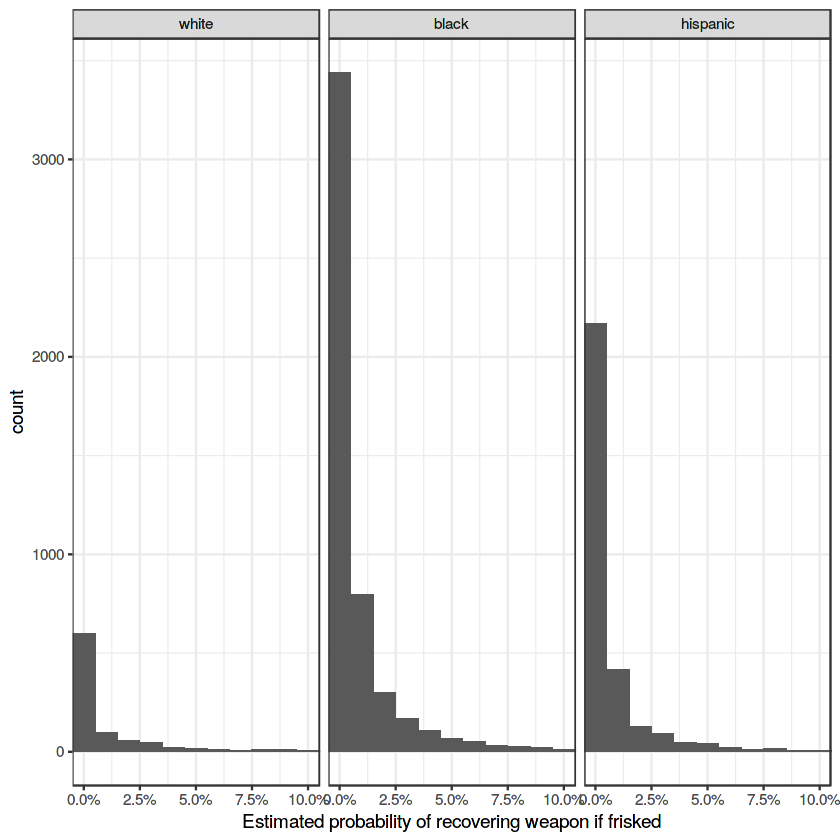

In [14]:
ggplot(filter(stop_df, suspect_race %in% c('white','black','hispanic')), aes(x = risk)) +
geom_histogram(binwidth = .01) +
facet_wrap(~ suspect_race) +
scale_x_continuous("Estimated probability of recovering weapon if frisked",
                   labels = scales::percent_format()) +
coord_cartesian(xlim = c(0, .1))

### Exercise 6: Frisk rates by estimated risk

Given risk estimates, consider individuals who have estimated risk between 4% and 5%. 
For each race group within this range of risk, compute: (1) the number stops; and (2) frisk rate.

Explore different ranges of risk. It might be helpful to refer to the histogram above to see roughly how many cases exist for each race group within each range of estimated risk.
Discuss your findings with your partner. What are some implications of these findings?

In [15]:
# WRITE CODE HERE
# START solution
stop_df %>%
    filter(risk >= .04, risk <= .05) %>%
    group_by(suspect_race) %>%
    summarize(N = n(),
              p_frisk = mean(frisked))
# END solution

`summarise()` ungrouping output (override with `.groups` argument)


suspect_race,N,p_frisk
<fct>,<int>,<dbl>
white,22,0.409
asian,3,0.667
black,81,0.815
hispanic,46,0.804
other,1,0.000


### Exercise 7: Risk-adjusted regression

Now compute risk-adjusted frisk rates for stopped individuals across different race groups.

How do these results compare to both the naive base rates and the "kitchen sink" approach?

In [16]:
# WRITE CODE HERE
# START solution
rar_model <- glm(frisked ~ suspect_race + risk, stop_df, family = binomial)
print(summary(rar_model))
# END solution


Call:
glm(formula = frisked ~ suspect_race + risk, family = binomial, 
    data = stop_df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.072  -1.254   0.978   1.084   1.387  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -0.4812     0.0685   -7.03  2.1e-12 ***
suspect_raceasian             0.4395     0.1343    3.27   0.0011 ** 
suspect_raceblack             0.6607     0.0731    9.04  < 2e-16 ***
suspect_racenative american   0.6090     0.3002    2.03   0.0425 *  
suspect_racehispanic          0.7499     0.0770    9.74  < 2e-16 ***
suspect_raceother             0.5575     0.1801    3.10   0.0020 ** 
risk                          7.0001     0.7268    9.63  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13250  on 9640  degrees of freedom
Residual deviance: 13021  on 9634  degrees of freedom
  (

### Exercise 8: Additional considerations

Even after adjusting for risk, disparities across certain features may still be justified.
For example, officers might enforce different standards for different location types: frisking individuals stopped in `transit` who they would not have frisked
if found in `housing`.  

Given the risk-adjusted regression results, what may be some other legitimate concerns? 
What are possible justifications for the racial disparities that persist after adjusting for risk? 
How could we revise our model to further account for such possibilities.

In [17]:
# WRITE CODE HERE
# START solution
rar_model <- glm(frisked ~ suspect_race + risk + location_housing, stop_df, family = binomial)
print(summary(rar_model))
# END solution


Call:
glm(formula = frisked ~ suspect_race + risk + location_housing, 
    family = binomial, data = stop_df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.072  -1.317   0.949   1.042   1.601  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -0.4411     0.0687   -6.42  1.4e-10 ***
suspect_raceasian             0.4289     0.1343    3.19  0.00141 ** 
suspect_raceblack             0.7628     0.0741   10.29  < 2e-16 ***
suspect_racenative american   0.6018     0.3008    2.00  0.04545 *  
suspect_racehispanic          0.7959     0.0773   10.30  < 2e-16 ***
suspect_raceother             0.5994     0.1809    3.31  0.00092 ***
risk                          6.7814     0.7153    9.48  < 2e-16 ***
location_housinghousing      -0.5165     0.0588   -8.78  < 2e-16 ***
location_housingtransit      -0.3382     0.0779   -4.34  1.4e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion 